#Optimizing Neural Networks for Image Classification: A Comprehensive Exploration of Strategies.



Finlay Campbell-Brady
University of Surrey
Guildford, England
fc00617@surrey.ac.uk
6832371

Harsh Marthak
University of Surrey
Guildford, England
hm01626@surrey.ac.uk
6839387

Shubham Kandpal
University of Surrey
Guildford, England
sk02593@surrey.ac.uk
6812009


### GRADIENT DESCENT

100%|██████████| 170498071/170498071 [00:05<00:00, 29488498.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/100, Test Loss: 2.2946, Test Accuracy: 15.59%
Epoch 2/100, Test Loss: 2.2638, Test Accuracy: 21.44%
Epoch 3/100, Test Loss: 2.1777, Test Accuracy: 28.10%
Epoch 4/100, Test Loss: 2.0527, Test Accuracy: 31.56%
Epoch 5/100, Test Loss: 1.9313, Test Accuracy: 33.43%
Epoch 6/100, Test Loss: 1.8406, Test Accuracy: 35.54%
Epoch 7/100, Test Loss: 1.7522, Test Accuracy: 37.55%
Epoch 8/100, Test Loss: 1.6947, Test Accuracy: 38.98%
Epoch 9/100, Test Loss: 1.6521, Test Accuracy: 40.63%
Epoch 10/100, Test Loss: 1.5817, Test Accuracy: 43.05%
Epoch 11/100, Test Loss: 1.4823, Test Accuracy: 47.55%
Epoch 12/100, Test Loss: 1.4130, Test Accuracy: 49.76%
Epoch 13/100, Test Loss: 1.4272, Test Accuracy: 49.50%
Epoch 14/100, Test Loss: 1.3374, Test Accuracy: 52.96%
Epoch 15/100, Test Loss: 1.2870, Test Accuracy: 54.37%
Epoch 16/100, Test Loss: 1.2698, Test Accuracy: 54.48%
Epoch 17/100, Test Loss: 1.2400, Test Ac

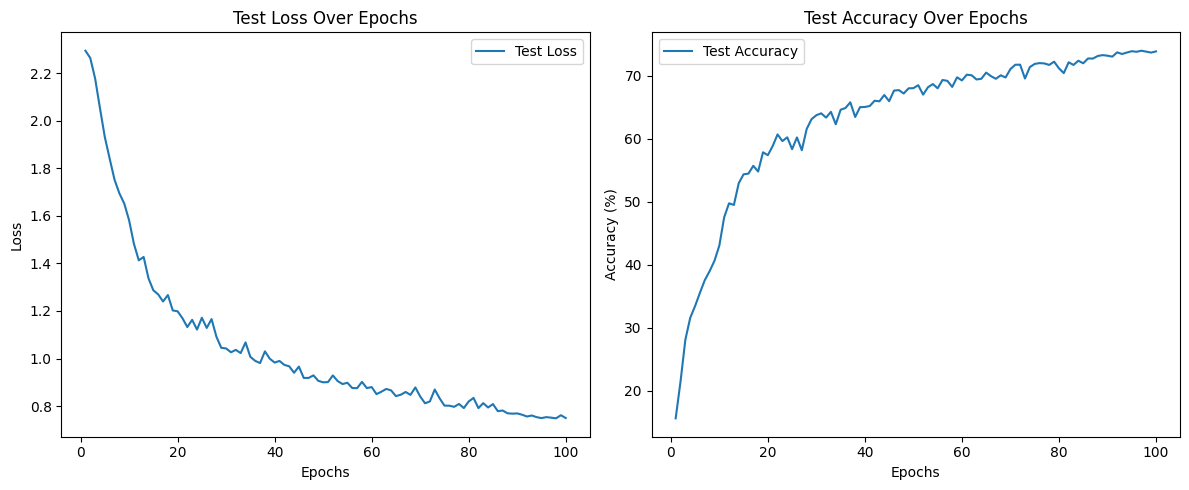

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the last fully connected layer
        x = self.fc2(x)
        return x

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12000, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=600, shuffle=True)

# Instantiate the model and move it to the GPU if available
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3)

# Load the model
loaded_model = SimpleCNN()

test_losses = []
test_accuracies = []

num_epochs = 100  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)


    accuracy = correct / total

    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.2f}%')

    # Plotting
plt.figure(figsize=(12, 5))

# Plot Test Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'simple_cnn_model2.pth')
print('Training finished. Model saved.')

In [ ]:
!pip install torchviz
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot

# Define the SimpleCNN class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the last fully connected layer
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the GPU if available
model = SimpleCNN().to(device)

# Load the saved model checkpoint
checkpoint = torch.load('simple_cnn_model2.pth', map_location=device)

# Check the keys in the checkpoint
print("Keys in the checkpoint:", checkpoint.keys())

# Use the correct key to load the model state dictionary
model.load_state_dict(checkpoint)

# Dummy input for visualization
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Forward pass to generate a computational graph
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph as a PNG image
graph.render("simple_cnn_model2_graph", format="png")

# Display the saved image file path
print(f"Graph saved as 'simple_cnn_model2_graph.png'")

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=bf8bc0b1844459bdd4ac9ae2e432a1b6e871c53d6fab6a9e78ff0c72aa9ae913
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Keys in the checkpoint: odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
Graph saved as 'simple_cnn_model2_graph.png'


### GENETIC ALGORITHM

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Accuracy: 0.6042
Epoch 2, Accuracy: 0.6752
Epoch 3, Accuracy: 0.6951
Epoch 4, Accuracy: 0.7090
Epoch 5, Accuracy: 0.7158
Epoch 1, Accuracy: 0.5933
Epoch 2, Accuracy: 0.6754
Epoch 3, Accuracy: 0.6964
Epoch 4, Accuracy: 0.7044
Epoch 5, Accuracy: 0.7136
Epoch 1, Accuracy: 0.5978
Epoch 2, Accuracy: 0.6687
Epoch 3, Accuracy: 0.6910
Epoch 4, Accuracy: 0.7063
Epoch 5, Accuracy: 0.7118
Epoch 1, Accuracy: 0.5993
Epoch 2, Accuracy: 0.6691
Epoch 3, Accuracy: 0.6914
Epoch 4, Accuracy: 0.7041
Epoch 5, Accuracy: 0.7116
Epoch 1, Accuracy: 0.5990
Epoch 2, Accuracy: 0.6740
Epoch 3, Accuracy: 0.6956
Epoch 4, Accuracy: 0.7074
Epoch 5, Accuracy: 0.7137
Epoch 1, Accuracy: 0.5889
Epoch 2, Accuracy: 0.6711
Epoch 3, Accuracy: 0.6938
Epoch 4, Accuracy: 0.7052
Epoch 5, Accuracy: 0.7112
Epoch 1, Accuracy: 0.6039
Epoch 2, Accuracy: 0.6753
Epoch 3, Accuracy: 0.6940
Epoch 4, Accuracy: 0.7013
Epoch 5, Accuracy: 0.7110
Epoch 1, Accur

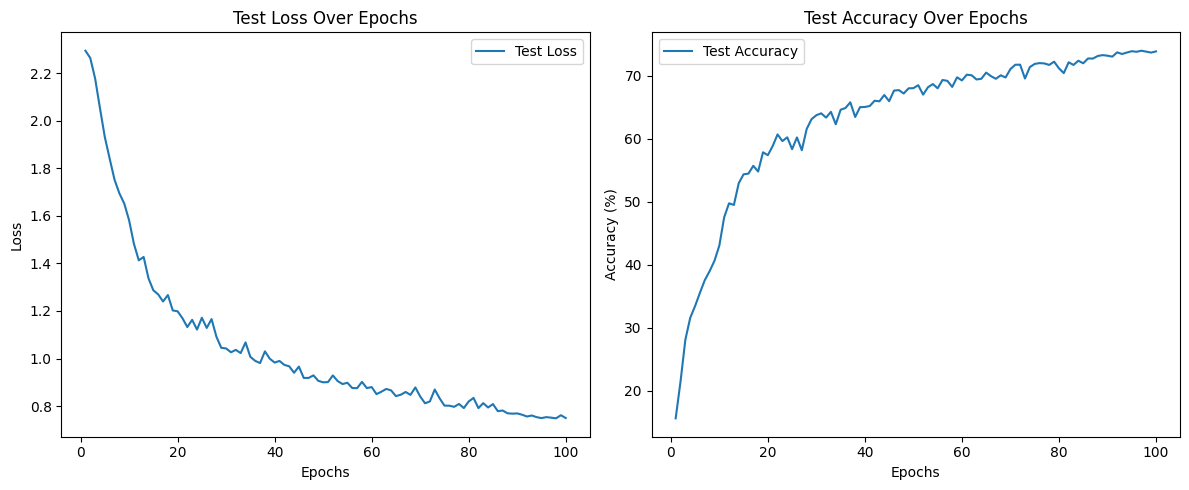

Training finished. Genetic algorithm model saved.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np
from sklearn.metrics import accuracy_score
import multiprocessing

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the CNN model with frozen layers
class FrozenCNN(nn.Module):
    def __init__(self, pretrained_model):
        super(FrozenCNN, self).__init__()

        # Load the weights from the pretrained model
        self.conv1 = pretrained_model.conv1
        self.bn1 = pretrained_model.bn1
        self.pool1 = pretrained_model.pool1
        self.conv2 = pretrained_model.conv2
        self.bn2 = pretrained_model.bn2
        self.pool2 = pretrained_model.pool2
        self.conv3 = pretrained_model.conv3
        self.dropout = pretrained_model.dropout
        self.fc1 = pretrained_model.fc1

        # Clone the last fully connected layer to avoid changing the weights of the original model
        self.fc2 = nn.Linear(pretrained_model.fc2.in_features, pretrained_model.fc2.out_features)

        # Freeze all layers except the last one
        for param in self.parameters():
            param.requires_grad = False
        self.fc2.weight.requires_grad = True
        self.fc2.bias.requires_grad = True

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the genetic algorithm function
def genetic_algorithm(model, population_size, generations, mutation_rate, train_loader, val_loader):
    best_weights = None
    best_accuracy = 0.0

    for generation in range(generations):
        population = [torch.randn_like(model.fc2.weight) for _ in range(population_size)]

        for weights in population:
            model.fc2.weight.data = weights.to(device)
            accuracy = train_and_evaluate(model, train_loader, val_loader)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_weights = weights.clone()

        # Mutation
        for i in range(1, population_size):
            mutation = torch.randn_like(best_weights) * mutation_rate
            population[i] = best_weights + mutation

        print(f"Generation {generation + 1}/{generations}, Best Accuracy: {best_accuracy:.4f}")

    print(f"Final Best Accuracy: {best_accuracy:.4f}")
    return best_weights


# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, lr=0.001, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1}, Accuracy: {accuracy:.4f}")

    return accuracy

population_size = 10
generations = 5
mutation_rate = 0.1
lr = 0.001
epochs = 5

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use multiple workers for faster data loading
num_workers = multiprocessing.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=num_workers)

# Load the pretrained model
pretrained_model = SimpleCNN()
pretrained_model.load_state_dict(torch.load('simple_cnn_model2.pth'))
pretrained_model.eval()

# Initialize the model with frozen layers
model = FrozenCNN(pretrained_model)

# Run the genetic algorithm
best_weights = genetic_algorithm(model, population_size, generations, mutation_rate, train_loader, val_loader)

# Set the best weights to the model
model.fc2.weight.data = best_weights.to(device)

# Train the entire model on the training set
train_and_evaluate(model, train_loader, val_loader, lr=lr, epochs=epochs)


plt.figure(figsize=(12, 5))

# Plot Test Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()


plt.tight_layout()
plt.show()

# Save the new model created by the genetic algorithm
torch.save(model.state_dict(), 'genetic_algorithm_model2.pth')
print('Training finished. Genetic algorithm model saved.')


### PSO & ADAM with Weight Decay

Files already downloaded and verified
Epoch 1/100, Loss: 1014.4256, Accuracy: 31.82%
Epoch 2/100, Loss: 882.2646, Accuracy: 39.72%
Epoch 3/100, Loss: 843.3807, Accuracy: 41.95%
Epoch 4/100, Loss: 825.2743, Accuracy: 42.83%
Epoch 5/100, Loss: 816.3081, Accuracy: 43.30%
Epoch 6/100, Loss: 813.1766, Accuracy: 43.77%
Epoch 7/100, Loss: 810.0176, Accuracy: 43.71%
Epoch 8/100, Loss: 808.0935, Accuracy: 44.23%
Epoch 9/100, Loss: 806.5202, Accuracy: 44.06%
Epoch 10/100, Loss: 804.8098, Accuracy: 44.38%
Epoch 11/100, Loss: 805.2956, Accuracy: 44.02%
Epoch 12/100, Loss: 804.8936, Accuracy: 44.10%
Reducing learning rate...
Epoch 13/100, Loss: 805.2110, Accuracy: 44.12%
Epoch 14/100, Loss: 802.0876, Accuracy: 44.52%
Epoch 15/100, Loss: 803.2365, Accuracy: 44.63%
Epoch 16/100, Loss: 800.7272, Accuracy: 44.34%
Epoch 17/100, Loss: 799.3523, Accuracy: 45.03%
Epoch 18/100, Loss: 798.7508, Accuracy: 44.88%
Epoch 19/100, Loss: 799.3523, Accuracy: 44.80%
Reducing learning rate...
Epoch 20/100, Loss: 801.1

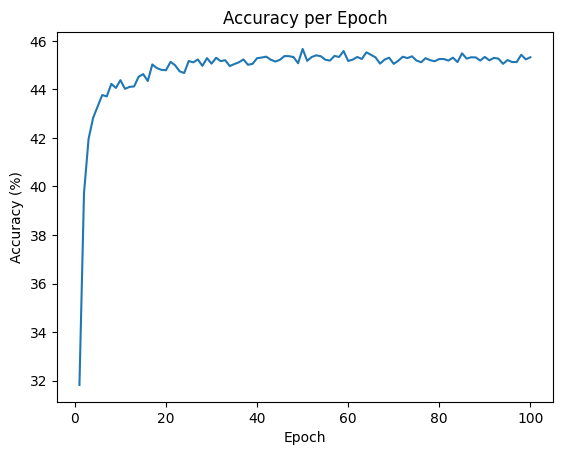

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the pretrained model on GPU
device = torch.device("cuda")
simple_cnn_model = SimpleCNN().to(device)
simple_cnn_model.load_state_dict(torch.load('simple_cnn_model2.pth', map_location=device))

# Function to initialize particle positions and velocities
def initialize_particles(params, device):
    particles = [param.data.clone().detach().requires_grad_(True).to(device) for param in params]
    velocities = [torch.zeros_like(param.data).to(device) for param in params]
    return particles, velocities

# Custom optimizer combining PSO and ADAM
class PSOAdamOptimizer:
    def __init__(self, model, lr_pso, lr_adam, weight_decay=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.model = model
        self.lr_pso = lr_pso
        self.lr_adam = lr_adam
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Initialize particles and velocities for the last layer
        self.last_layer_params = list(self.model.fc2.parameters())
        self.device = self.last_layer_params[0].device
        self.particles, self.velocities = initialize_particles(self.last_layer_params, self.device)

        # Initialize optimizer states
        self.state = {'step': 0, 'exp_avg': [torch.zeros_like(param.data).to(self.device) for param in self.last_layer_params],
                      'exp_avg_sq': [torch.zeros_like(param.data).to(self.device) for param in self.last_layer_params]}

    def zero_grad(self):
        for param in self.last_layer_params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def step(self, loss):
        # PSO update
        for param, particle, velocity in zip(self.last_layer_params, self.particles, self.velocities):
        # Ensure everything is on the same device
            particle = particle.to(param.device)
            velocity = velocity.to(param.device)
            r1 = torch.rand_like(param.data).to(param.device)
            r2 = torch.rand_like(param.data).to(param.device)

        # PSO updates
            velocity.data = self.lr_pso * (self.beta1 * velocity + r1 * (particle - param.data))
            param.data = param.data + velocity.data


        # ADAM update
        self.adam_update(loss)

    def adam_update(self, loss):
        for i, (param, exp_avg, exp_avg_sq) in enumerate(zip(self.last_layer_params,
                                                             self.state['exp_avg'], self.state['exp_avg_sq'])):
            state = self.get_state(i)
            state['step'] += 1

            exp_avg = exp_avg.to(param.device)
            exp_avg_sq = exp_avg_sq.to(param.device)
            param_grad = param.grad.data.to(param.device)

            exp_avg.data = self.beta1 * exp_avg + (1 - self.beta1) * param.grad.data
            exp_avg_sq.data = self.beta2 * exp_avg_sq + (1 - self.beta2) * param.grad.data**2

            bias_correction1 = 1 - self.beta1 ** state['step']
            bias_correction2 = 1 - self.beta2 ** state['step']

            step_size = self.lr_adam * (bias_correction2 ** 0.5) / bias_correction1

            param.data = param.data - step_size * exp_avg / (exp_avg_sq ** 0.5 + self.epsilon)

    def get_state(self, idx):
        if idx not in self.state:
            self.state[idx] = {'step': 0, 'exp_avg': torch.zeros_like(self.last_layer_params[idx].data).to(self.device),
                               'exp_avg_sq': torch.zeros_like(self.last_layer_params[idx].data).to(self.device)}
        return self.state[idx]

def train_model(model, optimizer, train_loader, epochs= 100, lr_reduce_patience=3, lr_reduce_factor=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0.0
    patience_counter = 0
    accuracy_per_epoch = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step(loss.item())

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_per_epoch.append(accuracy)

        # Learning rate adjustment based on training accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= lr_reduce_patience:
                optimizer.lr_pso *= lr_reduce_factor
                optimizer.lr_adam *= lr_reduce_factor
                print("Reducing learning rate...")
                patience_counter = 0

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return accuracy_per_epoch

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)

# Initialize the model
model = SimpleCNN()

# Freeze layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.fc2.parameters():
    param.requires_grad = True


# Initialize PSOAdam optimizer
pso_adam_optimizer = PSOAdamOptimizer(model, lr_pso=0.001, lr_adam=0.001)


# Train the model
accuracy_per_epoch = train_model(model, pso_adam_optimizer, train_loader, epochs=100)

# Save the model
torch.save(model.state_dict(), 'simple_cnn_model2_pso_adam.pth')

import matplotlib.pyplot as plt

# Ensure the range matches the length of accuracy_per_epoch
epochs_range = range(1, len(accuracy_per_epoch) + 1)

plt.plot(epochs_range, accuracy_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.show()

### NSGA-II

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


#### MULTI-OBJECTIVE

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100, Test Loss: 2.2949, Test Accuracy: 11.67%
Epoch 2/100, Test Loss: 2.2674, Test Accuracy: 27.16%
Epoch 3/100, Test Loss: 2.1997, Test Accuracy: 26.43%
Epoch 4/100, Test Loss: 2.0726, Test Accuracy: 28.64%
Epoch 5/100, Test Loss: 1.9511, Test Accuracy: 31.08%
Epoch 6/100, Test Loss: 1.9001, Test Accuracy: 31.14%
Epoch 7/100, Test Loss: 1.8370, Test Accuracy: 35.21%
Epoch 8/100, Test Loss: 1.7369, Test Accuracy: 36.44%
Epoch 9/100, Test Loss: 1.6705, Test Accuracy: 39.14%
Epoch 10/100, Test Loss: 1.5481, Test Accuracy: 44.58%
Epoch 11/100, Test Loss: 1.4512, Test Accuracy: 48.48%
Epoch 12/100, Test Loss: 1.3940, Test Accuracy: 50.33%
Epoch 13/100, Test Loss: 1.3649, Test Accuracy: 50.87%
Epoch 14/100, Test Loss: 1.3222, Test Accuracy: 53.48%
Epoch 15/100, Test Loss: 1.2973, Test Accuracy: 54.01%
Epoch 16/100, Test Loss: 1.2611, Test Accuracy: 55.64%
Epoch 17/100, Test Loss: 1.2720, Test Accuracy: 55.15

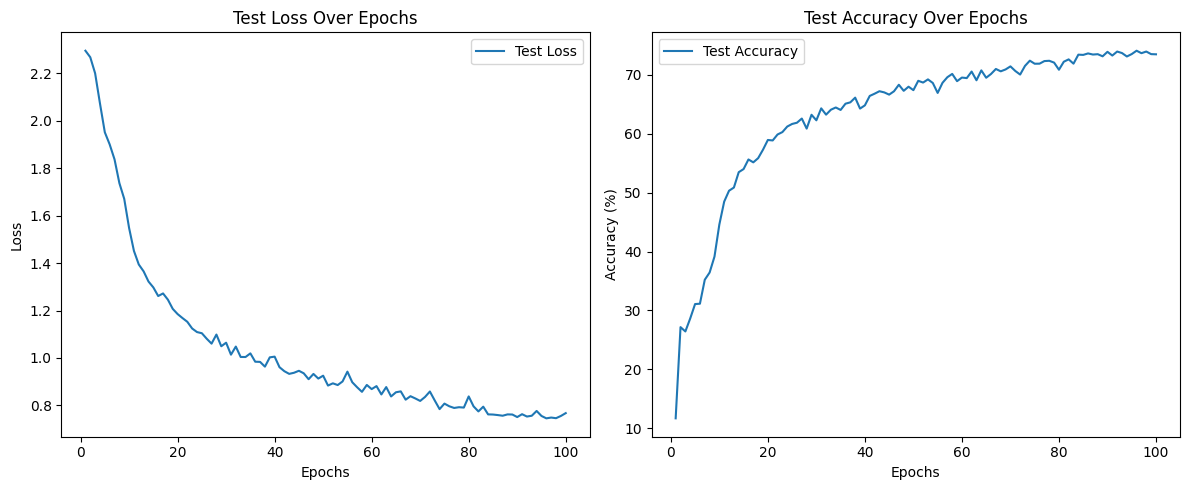

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12000, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=600, shuffle=True)

# Instantiate the model and move it to the GPU if available
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3)

# NSGA-II Multi-objective optimization problem definition
class MultiObjectiveProblem:
    def __init__(self, model, train_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader

    def evaluate(self, individual):
        # Set the model parameters with individual values
        self.set_parameters(individual)

        # Evaluate the model's performance on training and testing data
        train_accuracy, train_loss = self.test(self.train_loader)
        test_accuracy, test_loss = self.test(self.test_loader)

        # Return as a tuple of objectives
        return (1 - train_accuracy, train_loss, 1 - test_accuracy, test_loss)

    def test(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        total_loss = 0.0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        loss = total_loss / len(loader.dataset)
        return accuracy, loss

    def set_parameters(self, individual):
        # Set the model parameters with individual values
        for param, value in zip(self.model.parameters(), individual):
            param.data.copy_(torch.tensor(value, device=device))

# NSGA-II Training loop
def train_nsga2(model, train_loader, test_loader, num_generations=10, population_size=10):
    problem = MultiObjectiveProblem(model, train_loader, test_loader)

    # Define optimization objectives (minimize all objectives)
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initUniform, creator.Individual, -1, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)

    toolbox.register("evaluate", problem.evaluate)

    population = toolbox.population(n=population_size)

    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2 * population_size,
                             cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=None, halloffame=None, verbose=True)

    return [ind.fitness.values for ind in population], [ind for ind in population]

# Train and plot with NSGA-II
num_epochs = 100
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    accuracy, test_loss = MultiObjectiveProblem(model, train_loader, test_loader).test(test_loader)

    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    scheduler.step(test_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))

# Plot Test Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#### SINGLE OBJECTIVE MINIMIZING LOSS

In [ ]:
!pip install deap

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt

# Add the missing import statement
import torch.nn.functional as F

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12000, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=600, shuffle=True)

# Instantiate the model and move it to the GPU if available
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3)

# NSGA-II Single-objective optimization problem definition
class SingleObjectiveProblem:
    def __init__(self, model, train_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader

    def evaluate(self, individual):
        self.set_parameters(individual)
        _, test_loss = self.test(self.test_loader)
        return -test_loss  # Negative of test loss as a single objective (minimize test loss)

    def test(self, loader):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
        loss = total_loss / len(loader.dataset)
        return loss, loss

    def set_parameters(self, individual):
        for param, value in zip(self.model.parameters(), individual):
            param.data.copy_(torch.tensor(value, device=device))

# NSGA-II Training loop for Single-objective
def train_nsga2_single_objective(model, train_loader, test_loader, num_generations=10, population_size=10):
    problem = SingleObjectiveProblem(model, train_loader, test_loader)

    # Define optimization objectives (minimize the negative of the single objective)
    creator.create("FitnessSingle", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessSingle)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initUniform, creator.Individual, -1, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selBest)

    toolbox.register("evaluate", problem.evaluate)

    population = toolbox.population(n=population_size)

    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2 * population_size,
                             cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=None, halloffame=None, verbose=True)

    return [ind.fitness.values[0] for ind in population], [ind for ind in population]

# Train and plot with NSGA-II (Single-objective)
num_epochs = 100
test_losses = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    test_loss, _ = SingleObjectiveProblem(model, train_loader, test_loader).test(test_loader)
    test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss:.4f}')

# Plotting
plt.figure(figsize=(6, 4))

# Plot Test Loss
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


#### SINGLE OBJECTIVE GAUSSIAN REGULIZER

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt

# Add the missing import statement
import torch.nn.functional as F

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12000, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=600, shuffle=True)

# Instantiate the model and move it to the GPU if available
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3)

# NSGA-II Single-objective optimization problem definition
class SingleObjectiveProblem:
    def __init__(self, model, train_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader

    def evaluate(self, individual):
        self.set_parameters(individual)
        weight_sum = self.calculate_weight_sum()
        return weight_sum

    def calculate_weight_sum(self):
        weight_sum = 0.0
        for param in self.model.parameters():
            weight_sum += torch.sum(param.data ** 2).item()
        return weight_sum

    def set_parameters(self, individual):
        for param, value in zip(self.model.parameters(), individual):
            param.data.copy_(torch.tensor(value, device=device))

# NSGA-II Training loop for Single-objective
def train_nsga2_single_objective(model, train_loader, test_loader, num_generations=10, population_size=10):
    problem = SingleObjectiveProblem(model, train_loader, test_loader)

    # Define optimization objectives (minimize the single objective)
    creator.create("FitnessSingle", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessSingle)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initUniform, creator.Individual, -1, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selBest)

    toolbox.register("evaluate", problem.evaluate)

    population = toolbox.population(n=population_size)

    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2 * population_size,
                             cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=None, halloffame=None, verbose=True)

    return [ind.fitness.values[0] for ind in population], [ind for ind in population]

# Train and plot with NSGA-II (Single-objective)
num_epochs = 100
weight_sums = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    weight_sum = SingleObjectiveProblem(model, train_loader, test_loader).calculate_weight_sum()
    weight_sums.append(weight_sum)

    scheduler.step(weight_sum)

    print(f'Epoch {epoch + 1}/{num_epochs}, Weight Sum: {weight_sum:.4f}')

# Plotting
plt.figure(figsize=(6, 4))

# Plot Weight Sum
plt.plot(range(1, num_epochs + 1), weight_sums, label='Weight Sum')
plt.xlabel('Epochs')
plt.ylabel('Weight Sum')
plt.title('Weight Sum Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


#### BI-OBJECTIVE COMBINING BOTH OF THE ABOVE SINGLE OBJECTIVE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt

# Add the missing import statement
import torch.nn.functional as F

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12000, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=600, shuffle=True)

# Instantiate the model and move it to the GPU if available
model = SimpleCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3)

# NSGA-II Multi-objective optimization problem definition
class MultiObjectiveProblem:
    def __init__(self, model, train_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader

    def evaluate(self, individual):
        self.set_parameters(individual)

        # Evaluate the model's performance on training and testing data
        train_accuracy, train_loss = self.test(self.train_loader)
        test_accuracy, test_loss = self.test(self.test_loader)

        # Calculate the sum of square of weights
        weight_sum = self.calculate_weight_sum()

        # Return as a tuple of objectives
        return -train_accuracy, train_loss, weight_sum

    def test(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        total_loss = 0.0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        loss = total_loss / len(loader.dataset)
        return accuracy, loss

    def calculate_weight_sum(self):
        weight_sum = 0.0
        for param in self.model.parameters():
            weight_sum += torch.sum(param.data ** 2).item()
        return weight_sum

    def set_parameters(self, individual):
        # Set the model parameters with individual values
        for param, value in zip(self.model.parameters(), individual):
            param.data.copy_(torch.tensor(value, device=device))

# NSGA-II Training loop for Multi-objective
def train_nsga2_multi_objective(model, train_loader, test_loader, num_generations=10, population_size=10):
    problem = MultiObjectiveProblem(model, train_loader, test_loader)

    # Define optimization objectives (minimize all objectives)
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initUniform, creator.Individual, -1, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)

    toolbox.register("evaluate", problem.evaluate)

    population = toolbox.population(n=population_size)

    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2 * population_size,
                             cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=None, halloffame=None, verbose=True)

    return [ind.fitness.values for ind in population], [ind for ind in population]

# Train and plot with NSGA-II (Multi-objective)
num_epochs = 100
test_losses = []
test_accuracies = []
weight_sums = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    accuracy, test_loss = MultiObjectiveProblem(model, train_loader, test_loader).test(test_loader)
    weight_sum = MultiObjectiveProblem(model, train_loader, test_loader).calculate_weight_sum()

    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    weight_sums.append(weight_sum)

    scheduler.step(test_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.2f}, Weight Sum: {weight_sum:.4f}')

# Plotting
plt.figure(figsize=(12, 8))

# Plot Test Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

# Plot Test Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

# Plot Weight Sum
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), weight_sums, label='Weight Sum', color='red')
plt.xlabel('Epochs')
plt.ylabel('Weight Sum')
plt.title('Weight Sum Over Epochs')
plt.legend()

# Add a new subplot for combined objectives
plt.subplot(2, 2, 4)
combined_objectives = [-accuracy + 0.01 * weight_sum for accuracy, weight_sum in zip(test_accuracies, weight_sums)]
plt.plot(range(1, num_epochs + 1), combined_objectives, label='Combined Objectives', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Combined Objectives')
plt.title('Combined Objectives Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
